### Accessing the API

In [2]:
#stops annoying deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Variables that contains the credentials to access Twitter API
access_token = "1448945590046429231-T2ILZExNgwfyfMdNZOeqNddriW0zqY"
access_secret = "ov6408TNBm51LoLonCTdrkOxhTI4qyZ0vfWbCFBvwpY4M"
consumer_key = "nnZZPRiNSrpH3OkD8Mbmm8eK1"
consumer_secret = "LR12mPsQjJ6vOw8KTEBDlG5xHdOikQhXYHBUCpVuFlpfi2gaQ2"


# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Create API object
api = tweepy.API(auth, wait_on_rate_limit=True)



try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


### Retrieving tweets

We have to define what companies to include in the analysis. Ideally, I want to retrieve the top 10 monst mentioned companies of the week and use the model on them. For now, I'm just picking some arbitrary ones...

Also have to figure out how to query multiple companies together

In [3]:
Most_Active = ['$TSLA', '$AAPL', '$DOVA']   #important to add OR for the q parameter

In [4]:

#searching for mentions of tesla stock
#search_words = Most_Active + " -filter:retweets" # we can choose to filter retweets 

#date_since = "2020-10-01" This is not working / have to figure how to filter by time


#tweets = tweepy.Cursor(api.search_tweets,
#              q= search_words,
#              lang="en").items(100)



# fuction to extract data from tweet object
def extract_tweet_attributes(stocks):

    # create empty list
    tweet_list =[]
    
    #We iterate for each one of the companies in our original list
    for i in range(len(stocks)):
        
        tweets = tweepy.Cursor(api.search_tweets,
                  q= Most_Active[i] + " -filter:retweets",
                  lang="en").items(1000) # we are only pulling 100 tweets for testing purposes

        # loop through tweet objects
        for tweet in tweets:
            name = tweet.user.screen_name
            location = tweet.user.location
            verified = tweet.user.verified
            text = tweet.text # utf-8 text of tweet
            created_at = tweet.created_at # utc time tweet created
            source = tweet.source # utility used to post tweet
            retweets = tweet.retweet_count # number of times this tweet retweeted
            favorites = tweet.favorite_count # number of time this tweet liked


            # append attributes to list
            tweet_list.append({'name':name,
                               'location':location,
                               'verified':verified,
                               'text':text,
                               'created_at':created_at,
                               'source':source,
                               'retweets':retweets,
                               'favorites':favorites,
                               'Ticker': stocks[i]}) # have to append ticker name to reference later


        # create dataframe   
    df = pd.DataFrame(tweet_list, columns=['name',
                                            'location',
                                            'verified',
                                            'text',
                                            'created_at',
                                            'source',
                                            'retweets',
                                            'favorites',
                                            'Ticker'])
    
    
    return df


df = extract_tweet_attributes(Most_Active)

A big assumption that we are doing here is thay by querying by ticker we are essentially only getting financial sentiment for the company, and not necessarily product related data.

For example, we want tweets saying "AAPL stock is bad" rather than "Iphone is bad"

### Creating dataframe

The most important information is the following


From the user object information, we want:

- Screen Name
- Location
- Verified or not

From the tweet object information, we want:
- The time
- The tweet itself
- Number of retweets
- Favorites
- Source?? (maybe we'll see)

In [5]:
df.head()

,name,location,verified,text,created_at,source,retweets,favorites,Ticker
0,iamrgk_,"Atlanta, GA",False,@midwestmoviesus Money coming out of $TSLA and...,2021-11-16 13:58:01+00:00,Twitter for iPhone,0,0,$TSLA
1,Kyes501,,False,"For best alerts daily, join us!\n\nDiscord:\n\...",2021-11-16 13:57:48+00:00,Twitter for Android,0,0,$TSLA
2,Roger902102,,False,@heydave7 Dave - It would be nice to show how ...,2021-11-16 13:57:40+00:00,Twitter for iPhone,0,0,$TSLA
3,ITesla8,,False,"Please dips it hard, real hard today! $TSLA",2021-11-16 13:57:28+00:00,Twitter for iPhone,0,0,$TSLA
4,waterinsidegla1,,False,$TSLA @elonmusk is giving opportunity to othe...,2021-11-16 13:57:24+00:00,Twitter for iPhone,0,0,$TSLA


### Filtering Institutional Sentiment

We do this two ways: Filter out verified users and also through source of post (Web App Automation or TweetDeck), since they indicate whether the account is "professionaly" managed. The latter should be more than enough.

Still have to do this though

### Cleaning Tweets

Before going for the actual sentiment analysis, we need to clean all the junk from the data, such as URLs, numbers and IDs

In [6]:
import re

#dropping duplicates and resetting index
df=df.drop_duplicates(['text'])
df = df.reset_index(drop=True)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [7]:
df['text'] = clean_tweets(df['text'])

df['text'].head()

0     Money coming out of $TSLA and flowing into $RIVN
1    For best alerts daily, join us!\n\nDiscord:\n\...
2     Dave - It would be nice to show how much tax ...
3          Please dips it hard, real hard today! $TSLA
4    $TSLA   is giving opportunity to other investo...
Name: text, dtype: object

***Reminder to drop duplicates and filter institutional stuff!!!***

### Word Cloud

We can also plot a nice world cloud to visualize what are the words people talk most about

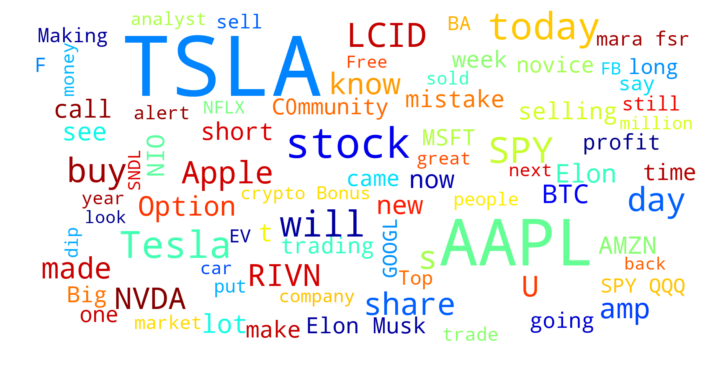

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

word_cloud(df['text'])

### Sentiment Analysis - VADER

We start off the analysis with pre-trained models. The first one is VADER, which is specifically attuned for social media data

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
print(analyzer.polarity_scores("I fucking hate this!"))
print(analyzer.polarity_scores("I fucking love this!"))

{'neg': 0.588, 'neu': 0.412, 'pos': 0.0, 'compound': -0.6468}
{'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'compound': 0.6989}


In [ ]:
#just checking out scores of individual words to see how it works
token_scores = analyzer.lexicon
token_scores['love']

NameError: name 'analyzer' is not defined

In [12]:
scores_vader = []

# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df['text'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyzer.polarity_scores(df['text'][i])["compound"]
    pos = analyzer.polarity_scores(df['text'][i])["pos"]
    neu = analyzer.polarity_scores(df['text'][i])["neu"]
    neg = analyzer.polarity_scores(df['text'][i])["neg"]
    
    scores_vader.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })

We can now join the scores into the dataframe and have much richer data to work with!

In [13]:
sentiments_score_vader = pd.DataFrame.from_dict(scores_vader)
df_vader = df.join(sentiments_score_vader)
df_vader.head()

,name,location,verified,text,created_at,source,retweets,favorites,Ticker,Compound,Positive,Negative,Neutral
0,iamrgk_,"Atlanta, GA",False,Money coming out of $TSLA and flowing into $RIVN,2021-11-16 13:58:01+00:00,Twitter for iPhone,0,0,$TSLA,0.0000,0.000,0.000,1.000
1,Kyes501,,False,"For best alerts daily, join us!\n\nDiscord:\n\...",2021-11-16 13:57:48+00:00,Twitter for Android,0,0,$TSLA,0.6114,0.264,0.106,0.630
2,Roger902102,,False,Dave - It would be nice to show how much tax ...,2021-11-16 13:57:40+00:00,Twitter for iPhone,0,0,$TSLA,0.6597,0.231,0.000,0.769
3,ITesla8,,False,"Please dips it hard, real hard today! $TSLA",2021-11-16 13:57:28+00:00,Twitter for iPhone,0,0,$TSLA,0.2003,0.221,0.298,0.481
4,waterinsidegla1,,False,$TSLA is giving opportunity to other investo...,2021-11-16 13:57:24+00:00,Twitter for iPhone,0,0,$TSLA,0.8225,0.390,0.000,0.610


### Entity Recognition

For now, the only entity recognition we are doing is hashtags, where we can look at the positive ones

In [14]:
HT_positive = []
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from  tweets
HT_positive = hashtag_extract(df_vader['text'][df_vader['Compound'] > 0.5])
# unnesting list
HT_positive = sum(HT_positive,[])
HT_positive

['watchlist',
 'charts',
 'OIL',
 'growth',
 'millionaire',
 'money',
 'success',
 'tuesdayvibe',
 'WDL',
 'Gold',
 'crypto',
 'Bitcoin',
 'fintwit',
 'Free',
 'Money',
 'fintwit',
 'fintwit',
 'Tesla',
 'stockmarket',
 'stock',
 'fintwit',
 'fintwit',
 'TikTok',
 'fintwit',
 'Bearish',
 'Bullish',
 'fintwit',
 'fintwit',
 'fintwit',
 'WSB',
 'fintwit',
 'Tesla',
 'fintwit',
 'fintwit',
 'options',
 'watchlist',
 'stocks',
 'daytrading',
 'NYSE',
 'NASDAQ',
 'market',
 'StockMarket',
 'Bubble',
 'FAANG',
 'WarrenBuffett',
 'investing',
 'daytrading',
 'stocks',
 'watchlist',
 'Viral',
 '1',
 'Bitcoin',
 'WOW',
 'Options',
 'fintwit',
 'Options',
 'maxpain',
 'fintwit',
 'Options',
 'AAPL',
 'Biden',
 'Democrats',
 'TAX',
 'TaxTheRich',
 'WhaleStream',
 'WhaleFlow',
 'shiba',
 'shibainu',
 'doge',
 'Metaverse',
 'money',
 'Bitcoin',
 'Options',
 'IONICBRANDS',
 'fintwit',
 'fintwit',
 'BTC',
 'ETH',
 'Patent',
 '3112']

In [15]:
#Collect the compound values for each news source
#this shows us mean sentiment for each company
score_table = df_vader.pivot_table(index='Ticker',  values="Compound", aggfunc = np.mean)
score_table

,Compound
Ticker,
$AAPL,0.171077
$DOVA,-0.325736
$TSLA,0.139451


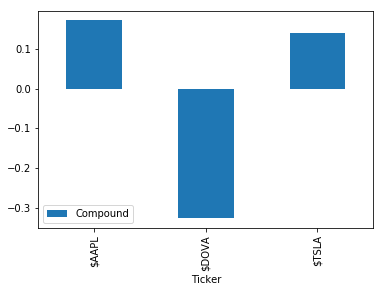

In [16]:
#plotting 
score_table.plot(kind='bar')

This score that we see is not weighted -- NOT GOOD. We have to consider retweets / favorites there

### Sentiment Analysis - TextBlob

TextBlob performs better with formal language, might not perform as well 

In [17]:
from textblob import TextBlob

In [18]:
test = TextBlob('TSLA stock is going down')
test.sentiment

Sentiment(polarity=-0.15555555555555559, subjectivity=0.2888888888888889)

In [19]:
scores_blob = []

# Declare variables for scores
polarity = []
subjectivity = []

for i in range(df['text'].shape[0]):
    polarity = TextBlob(df['text'][i]).sentiment[0]
    subjectivity = TextBlob(df['text'][i]).sentiment[1]
    
    scores_blob.append({"Polarity": polarity,
                       "Subjectivity": subjectivity
                  })
    

In [20]:
sentiments_score_blob = pd.DataFrame.from_dict(scores_blob)
df_blob = df.join(sentiments_score_blob)
df_blob.head()

,name,location,verified,text,created_at,source,retweets,favorites,Ticker,Polarity,Subjectivity
0,iamrgk_,"Atlanta, GA",False,Money coming out of $TSLA and flowing into $RIVN,2021-11-16 13:58:01+00:00,Twitter for iPhone,0,0,$TSLA,0.000000,0.000000
1,Kyes501,,False,"For best alerts daily, join us!\n\nDiscord:\n\...",2021-11-16 13:57:48+00:00,Twitter for Android,0,0,$TSLA,0.500000,0.150000
2,Roger902102,,False,Dave - It would be nice to show how much tax ...,2021-11-16 13:57:40+00:00,Twitter for iPhone,0,0,$TSLA,0.400000,0.600000
3,ITesla8,,False,"Please dips it hard, real hard today! $TSLA",2021-11-16 13:57:28+00:00,Twitter for iPhone,0,0,$TSLA,-0.419271,0.677083
4,waterinsidegla1,,False,$TSLA is giving opportunity to other investo...,2021-11-16 13:57:24+00:00,Twitter for iPhone,0,0,$TSLA,-0.125000,0.375000


In [21]:
HT_positive = []

HT_positive = hashtag_extract(df_blob['text'][df_blob['Polarity'] > 0.2])
# unnesting list
HT_positive = sum(HT_positive,[])
HT_positive

['douchecoin',
 'IonicBrands',
 'CSE',
 'OTC',
 'CBD',
 'ETH',
 'BTC',
 'stockmarkets',
 'StocksToBuy',
 'stocks',
 'stockmarkets',
 'StocksToBuy',
 'stocks',
 'FTD',
 'watchlist',
 'charts',
 'OIL',
 'PressRelease',
 'OTC',
 'FOMO',
 'growth',
 'millionaire',
 'money',
 'success',
 'tuesdayvibe',
 'WDL',
 'fintwit',
 'GCG',
 'Clon',
 'Stocks',
 'socialmedia',
 'wallstreetbets',
 'Hertz',
 'WSB',
 'Reddit',
 'Stonks',
 'Moass',
 'fintwit',
 'ElonMusk',
 'fintwit',
 'fintwit',
 'fintwit',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 'Stocks',
 'Rivian',
 'TSLA',
 'fintwit',
 'fintwit',
 'TikTok',
 'fintwit',
 'Tesla',
 'redditarmy',
 'stocks',
 'redditarmy',
 'stocks',
 'fintwit',
 'fintwit',
 'speculating',
 'fintwit',
 'ARKInvest',
 'Elon',
 'Tesla',
 'fintwit',
 'TSLA',
 'Rivian',
 'TeslaChina',
 'Tesla',
 'WSB',
 'redditarmy',
 'stocks',
 'fintwit',
 'fintwit',
 'WSB',
 'fintwit',
 'options',
 'watchlist',
 'FTD',
 'Apple',
 'economy',
 'trading',
 'investing',
 'InvestorPicks',
 'ell

In [22]:
#Collect the compound values for each news source
score_table = df_blob.pivot_table(index='Ticker',  values="Polarity", aggfunc = np.mean)
score_table

,Polarity
Ticker,
$AAPL,0.120011
$DOVA,0.007748
$TSLA,0.104487


Definitely some difference going on here. But at the core it's still kinda of the same sentiment. Positive for Apple and Tesla (with Apple at the forefront), but Dova instead of negative turns into neutral, which is not nice

Might have to check Vader's other two scores since just compound is not enough to answer.

Possible Problem ahead: Figuring out how to quantify uncertainity... Might just add an uncertain column into the dataframe, or make a weighted single score based on that.


Lastly there's something funky going on with text input here. I might have to take out all the emojis because I think they are throwing of TextBlob

### Sentiment Analysis - SentiWordNet

For this one we actually need the lemma of each word, so there's some extra cleaning here to do.

This is probably not going to work well since Tweets are filled with typos and non-dictionary words which Sentiwordnet often times does not recognize. To

In [23]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text


#duplicates the dataframe
df_swn = df

# Cleaning the text in the review column
df_swn['text'] = df_swn['text'].apply(clean)

In [24]:
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('wordnet')
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist



df_swn['POS tagged'] = df_swn['text'].apply(token_stop_pos)
df_swn.head()

,name,location,verified,text,created_at,source,retweets,favorites,Ticker,POS tagged
0,iamrgk_,"Atlanta, GA",False,Money coming out of TSLA and flowing into RIVN,2021-11-16 13:58:01+00:00,Twitter for iPhone,0,0,$TSLA,"[(Money, n), (coming, v), (TSLA, n), (flowing,..."
1,Kyes501,,False,For best alerts daily join us Discord DSA KODK...,2021-11-16 13:57:48+00:00,Twitter for Android,0,0,$TSLA,"[(best, a), (alerts, n), (daily, r), (join, v)..."
2,Roger902102,,False,Dave It would be nice to show how much tax ts...,2021-11-16 13:57:40+00:00,Twitter for iPhone,0,0,$TSLA,"[(Dave, v), (would, None), (nice, a), (show, v..."
3,ITesla8,,False,Please dips it hard real hard today TSLA,2021-11-16 13:57:28+00:00,Twitter for iPhone,0,0,$TSLA,"[(Please, n), (dips, v), (hard, a), (real, a),..."
4,waterinsidegla1,,False,TSLA is giving opportunity to other investors...,2021-11-16 13:57:24+00:00,Twitter for iPhone,0,0,$TSLA,"[(TSLA, n), (giving, v), (opportunity, n), (in..."


A lot of stuff going on here.

1) Tokenization: breaks text into small pieces (tokens)

2) POS Tagging: converting each token into a tuple

3) Remove stopwords: they are just noise with no information, unless we tokenized sentences (which I believe it's something people do, but I'm not doing it now)

We are doing all of this extra cleaning because we wanted emojis and other signs to be considered, but that doesn't work with SentiWordNet

For reference, I adapted some code from here
https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/

In [25]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

#takes pos_tag tuples, and gives the Lemma for each word in pos_tag based on the pos of that word. 
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df_swn['Lemma'] = df_swn['POS tagged'].apply(lemmatize)

The last part of cleaning this mess is Lemmatization. To get the accurate Lemma from SentiWord, we need the POS tags, which we can now map them together in a dictionary.

Any pos_tag that starts with J is mapped to wordnet.ADJ, any pos_tag that starts with R is mapped to wordnet.ADV, and so on

n - NOUN 

v - VERB

a - ADJECTIVE 

s - ADJECTIVE SATELLITE

r - ADVERB 

In [26]:
df_swn[['POS tagged', 'Lemma']][0:1] # an example of how this looks like

,POS tagged,Lemma
0,"[(Money, n), (coming, v), (TSLA, n), (flowing,...",Money come TSLA flow RIVN


Lemmatization will also be useful in the future when we take the machine learning approach

We can finally use SentiWordNet now.

In [27]:
#nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        
    if not tokens_count:
        return 0
    return sentiment


df_swn['SWN'] = df_swn['POS tagged'].apply(sentiwordnetanalysis)
df_swn.head()

,name,location,verified,text,created_at,source,retweets,favorites,Ticker,POS tagged,Lemma,SWN
0,iamrgk_,"Atlanta, GA",False,Money coming out of TSLA and flowing into RIVN,2021-11-16 13:58:01+00:00,Twitter for iPhone,0,0,$TSLA,"[(Money, n), (coming, v), (TSLA, n), (flowing,...",Money come TSLA flow RIVN,0.000
1,Kyes501,,False,For best alerts daily join us Discord DSA KODK...,2021-11-16 13:57:48+00:00,Twitter for Android,0,0,$TSLA,"[(best, a), (alerts, n), (daily, r), (join, v)...",best alert daily join us Discord DSA KODK DO...,0.000
2,Roger902102,,False,Dave It would be nice to show how much tax ts...,2021-11-16 13:57:40+00:00,Twitter for iPhone,0,0,$TSLA,"[(Dave, v), (would, None), (nice, a), (show, v...",Dave would nice show much tax tsla growth ge...,1.000
3,ITesla8,,False,Please dips it hard real hard today TSLA,2021-11-16 13:57:28+00:00,Twitter for iPhone,0,0,$TSLA,"[(Please, n), (dips, v), (hard, a), (real, a),...",Please dip hard real hard today TSLA,-1.375
4,waterinsidegla1,,False,TSLA is giving opportunity to other investors...,2021-11-16 13:57:24+00:00,Twitter for iPhone,0,0,$TSLA,"[(TSLA, n), (giving, v), (opportunity, n), (in...",TSLA give opportunity investor buy tesla sha...,0.875


There is an alternative way to do this in this guide
https://towardsdatascience.com/sentiment-analysis-on-swachh-bharat-using-twitter-216369cfa534

They do lemmatization differently, and I might adapt later

### Sentiment Analysis - Flair

Flair’s sentiment classifier is based on a character-level LSTM neural network which takes sequences of letters and words into account when predicting

This will be the last of the lexicon-based sentiment analysis models.

In [28]:
#still have to code this part

### Sentiment Analysis - NTUSD-Fin

https://www.cs.nccu.edu.tw/~hhhuang/docs/fnp2018.pdf

"a market sentiment dictionary based on more than 330K labeled posts crawled from financial social media. There are 8,331 words, 112 hashtags and 115 emojis in our dictionary"

This is especially nice because some words like Buy / Sell have a neutral (0.0) score on other dictionaries, and this is obviously not the case when we are talking about finance.

In [38]:
ntusd_word = pd.read_json('NTUSD_Fin_word_v1.0.json')

ntusd_word['token'].unique

<bound method Series.unique of 0             notes
1       manipulator
2            sucked
3            garage
4              aids
           ...     
8326        pharmas
8327         barrel
8328            cll
8329          dough
8330        tencent
Name: token, Length: 8331, dtype: object>

### Comparing Rule-based Models

I have to think of some nice visualizations and comparisons to make between the three models...

Talk about differences in results and which of them are more reliable, etc

Don't forget to include discussion about emoji representation, since it seems to play a large role in classification

In [29]:
# I sort of know the visualizations I want to include, but want to focus on getting the machine learning models first
# nothing here for now...

### Using Pre-trained Data

There is nothing that stops us from using our rule based sentiment as training data to predict new tweets, however this wouldn't be productive since we could 1) just apply the rules into new tweets 2) there is no way to assess how accurate the training is anyways.

Therefore, an alternative approach that we can use is downloading data containing tweets that were manually pre-labelled and use that as our training set for more sophisticated models.

It will be interesting to compare how well they will compare to our previous examples.

Datasets:
http://help.sentiment140.com/for-students

https://nlp.stanford.edu/sentiment/code.html

https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf



I'm struggling to get this to work

This has actually been difficult to figure out, I need more time to source what datasets to use (this is also a very important aspect of the capstone)


In [39]:
# I have no idea how to open this, something to do with characters being invalid with utf-8 encoding


columns = ['target','ids','date','flag','user','text']
stanford_train = pd.read_csv('stanford_treebank.csv',encoding='ANSI', names = columns)


~~Since I can't get this to work, I'm just going to use some of the tweets we already classified as training data~~

Figured it out

- “token”: word, hashtag, or emoji
- “bull_freq”: frequency in bullish set.
- “bear_freq”: frequency in bearish set
- “bull_cfidf”: collection frequency in bullish set.
- “bear_cfidf”: collection frequency in bearish set.
- “chi_squared”: chi squared test result of the token.
- “market_sentiment”: calculated by bullish PMI minus bearish PMI.
- “word_vec”: 300-dimension word vector.

In [40]:
stanford_train.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [41]:
stanford_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


We can take a look at the target variables. It's well distributed, so we don't have to worry about this part as opposed to the other methods (eg. a lot more negatives than positives).

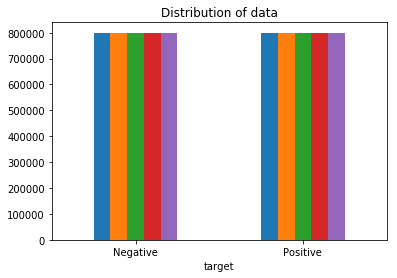

In [42]:
# Plotting the distribution for dataset.
ax = stanford_train.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(stanford_train['text']), list(stanford_train['target'])

In [35]:
print(stanford_train['target'].unique())

#changes 4 to 1 for simplicity
stanford_train['target'] = stanford_train['target'].replace(4,1)

stanford_positive = stanford_train[stanford_train['target'] == 1]
stanford_negative = stanford_train[stanford_train['target'] == 0]

[0 4]


In [36]:
stanford_train = pd.concat([stanford_positive, stanford_negative])

In [37]:
stanford_train

,target,ids,date,flag,user,text
800000,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
799995,0,2329205009,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...
799996,0,2329205038,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?
799997,0,2329205473,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad
799998,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...


### Sentiment Analysis - Naive Bayes

This will involved the following:

- bulding vocabulary
- matching tweets against vocabulary
- building a feature vector
- training the classifier

We start with naive bayes because it's simple enough and can set a baseline for others

In [54]:
def buildVocabulary(preprocessedTrainingData):
    all_words = []
    
    for (words, sentiment) in preprocessedTrainingData:
        all_words.extend(words)

    wordlist = nltk.FreqDist(all_words)
    word_features = wordlist.keys()
    
    return word_features

In [55]:
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in tweet_words)
    return features 

In [ ]:
word_features = buildVocabulary()
trainingFeatures = nltk.classify.apply_features()

In [ ]:
NBayesClassifier = nltk.NaiveBayesClassifier.train(trainingFeatures)

### Sentiment Analysis - Clustering

Inspiration from here

https://medium.com/analytics-vidhya/tweet-analytics-using-nlp-f83b9f7f7349

In [58]:
def cluster_text(dist_text,processedTweets,dist_threshold_txt):
    cluster_id = 1
    for i in range(dist_text.shape[0]):
        try:
            doc_dist_array_txt = dist_text[i,]
            # identify document ids where the tweets are similar
            similarDocs = np.where(doc_dist_array_txt <= dist_threshold_txt)[0]
            processedTweets.ix[processedTweets.index.isin(similarDocs) & processedTweets['cluster_ref'].isin([None]), 'cluster_ref'] = cluster_id
            cluster_id = cluster_id + 1
        except ValueError:
            continue

    return processedTweets

Calculating cosine distance

In [ ]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [59]:
def get_clusters(processedTweets, similarity_threshold):
    tweets = processedTweets['text'].tolist()

    vectorizer =  CountVectorizer(max_df=1.0, min_df=1, stop_words=stopwords, tokenizer=tokenize_only) 

    dtf_matrix = vectorizer.fit_transform(tweets) 
    dist_text = np.around(abs(1 - cosine_similarity(dtf_matrix)),2)
    
    processedTweets['cluster_ref'] = None

    processedTweets = cluster_text(dist_text,processedTweets,dist_threshold_txt = (1-similarity_threshold))
    
    
    return processedTweet

### Topic Modelling with Latent Dirichlet Allocation (LDA)

Start with topic extraction

In [64]:
import lda # topic modeling -NMF & LDA
import string
from nltk.tag import StanfordNERTagger
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tf-Idf and Clustering packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import tokenize as tok

df_lda = df

In [47]:
# Helper functions
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) 

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
     

In [65]:
# parameter for lda
number_topics = 5
number_words = 5

In [66]:
def topic_extraction(dataframe):

    tweets_all_topics= pd.DataFrame()
    
    # term frequency modelling
    for terms in dataframe['Ticker'].unique():
        print(terms)
        tweets_search_topics  = dataframe[dataframe['Ticker']==terms].reset_index(drop=True)
        
        corpus = tweets_search_topics['Lemma'].tolist()
        # print(corpus)
        tf_vectorizer = CountVectorizer(max_df=0.9, min_df=0.00, tokenizer=tokenize_only) # Use tf (raw term count) features for LDA.
        tf = tf_vectorizer.fit_transform(corpus)

        # Create and fit the LDA model
        model = LDA(n_components=number_topics, n_jobs=-1)
        id_topic = model.fit(tf)
        # Print the topics found by the LDA model
        print("Topics found via LDA:")
        topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=model, n_words=number_words)        
        # Topic - Keywords Dataframe
        df_topic_keywords = pd.DataFrame(topic_keywords)
        df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
        df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
        df_topic_keywords = df_topic_keywords.reset_index()
        df_topic_keywords['topic_index'] = df_topic_keywords['index'].str.split(' ', n = 1, expand = True)[[1]].astype('int')
        print(df_topic_keywords)

        ############ get the dominat topic for each document in a data frame ###############
        # Create Document — Topic Matrix
        lda_output = model.transform(tf)
        # column names
        topicnames = ["Topic" + str(i) for i in range(model.n_components)]
        # index names
        docnames = ["Doc" + str(i) for i in range(len(corpus))]

        # Make the pandas dataframe
        df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
        # Get dominant topic for each document
        dominant_topic = np.argmax(df_document_topic.values, axis=1)
        df_document_topic['dominant_topic'] = dominant_topic   
        df_document_topic = df_document_topic.reset_index()

        #combine all the search terms into one data frame
        tweets_topics = tweets_search_topics.merge(df_document_topic, left_index=True, right_index=True, how='left')
        tweets_topics_words = tweets_topics.merge(df_topic_keywords, how='left', left_on='dominant_topic', right_on='topic_index')
        tweets_all_topics = tweets_all_topics.append(tweets_topics_words)
    
    return tweets_all_topics


In [71]:
df_lda = topic_extraction(df_lda)

$TSLA
Topics found via LDA:
     index Word 0 Word 1 Word 2 Word 3 Word 4  topic_index
0  Topic 0   tsla  tesla    buy   rivn   lcid            0
1  Topic 1   tsla   elon  tesla   sell  alert            1
2  Topic 2   tsla   lcid    gme   mara  today            2
3  Topic 3   tsla  tesla   sell    buy   elon            3
4  Topic 4   tsla   aapl  stock  short     fb            4
$AAPL
Topics found via LDA:
     index Word 0 Word 1  Word 2 Word 3 Word 4  topic_index
0  Topic 0   aapl    spy    tsla   call    qqq            0
1  Topic 1   aapl   tsla    live    btc  today            1
2  Topic 2   aapl    spy    make   tsla  trade            2
3  Topic 3   aapl  apple     new  alert    top            3
4  Topic 4   aapl     fb  change   tsla    gme            4
$DOVA
Topics found via LDA:
     index  Word 0        Word 1  Word 2    Word 3 Word 4  topic_index
0  Topic 0  coming  confirmation  credit  friendly     jp            0
1  Topic 1  coming  confirmation  credit  friendly     jp   

In [73]:
df_lda = df_lda.reset_index(drop=True)
print(df_lda.shape)
df_lda.head()

(1942, 26)


,name,location,verified,text,created_at,source,retweets,favorites,Ticker,POS tagged,...,Topic3,Topic4,dominant_topic,index_y,Word 0,Word 1,Word 2,Word 3,Word 4,topic_index
0,iamrgk_,"Atlanta, GA",False,Money coming out of TSLA and flowing into RIVN,2021-11-16 13:58:01+00:00,Twitter for iPhone,0,0,$TSLA,"[(Money, n), (coming, v), (TSLA, n), (flowing,...",...,0.03,0.03,1,Topic 1,tsla,elon,tesla,sell,alert,1
1,Kyes501,,False,For best alerts daily join us Discord DSA KODK...,2021-11-16 13:57:48+00:00,Twitter for Android,0,0,$TSLA,"[(best, a), (alerts, n), (daily, r), (join, v)...",...,0.01,0.01,2,Topic 2,tsla,lcid,gme,mara,today,2
2,Roger902102,,False,Dave It would be nice to show how much tax ts...,2021-11-16 13:57:40+00:00,Twitter for iPhone,0,0,$TSLA,"[(Dave, v), (would, None), (nice, a), (show, v...",...,0.01,0.01,1,Topic 1,tsla,elon,tesla,sell,alert,1
3,ITesla8,,False,Please dips it hard real hard today TSLA,2021-11-16 13:57:28+00:00,Twitter for iPhone,0,0,$TSLA,"[(Please, n), (dips, v), (hard, a), (real, a),...",...,0.03,0.03,2,Topic 2,tsla,lcid,gme,mara,today,2
4,waterinsidegla1,,False,TSLA is giving opportunity to other investors...,2021-11-16 13:57:24+00:00,Twitter for iPhone,0,0,$TSLA,"[(TSLA, n), (giving, v), (opportunity, n), (in...",...,0.52,0.02,3,Topic 3,tsla,tesla,sell,buy,elon,3


In [76]:
df_lda.to_csv('processed_data/df_lda.csv', index=False)

### Train the Model

### Correlation with Price

In [68]:
#sentiment analysis with price correlation: opening - closing

2